In [24]:
import pandahouse as ph
import seaborn as sns
import numpy as np
from statsmodels.graphics.gofplots import qqplot_2samples


connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database': 'simulator_20230220',
              'user': 'student',
              'password': 'dpo_python_2020'
              }

ModuleNotFoundError: No module named 'stl'

In [2]:
query = """SELECT * FROM {db}.feed_actions limit 200000"""
df = ph.read_clickhouse(query=query, connection=connection)

In [3]:
df.head()

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,242,18,view,2023-01-04 00:09:20,0,47,Russia,Moscow,Android,ads,3
1,242,18,like,2023-01-04 00:10:10,0,47,Russia,Moscow,Android,ads,3
2,107710,18,view,2023-01-04 00:11:43,0,19,Russia,Novosibirsk,iOS,organic,0
3,107382,75,view,2023-01-04 00:11:45,0,35,Belarus,Kobryn,iOS,organic,2
4,107382,18,view,2023-01-04 00:13:58,0,35,Belarus,Kobryn,iOS,organic,2


In [4]:
agg_df = df[["post_id", "action", "user_id"]].groupby(["post_id", "action"], 
                                                       as_index = False).count() \
    .pivot(index = "post_id", columns="action", values="user_id")

In [5]:
agg_df.fillna(0).describe().round(2)

action,like,view
count,891.00,891.00
mean,39.66,184.81
std,50.81,171.05
min,0.00,1.00
25%,7.00,58.50
50%,20.00,133.00
75%,54.00,268.00
max,428.00,1474.00


<AxesSubplot:xlabel='view', ylabel='Count'>

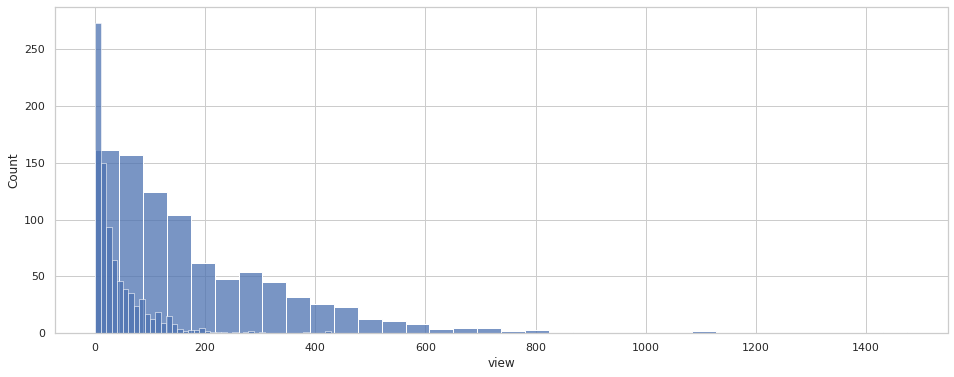

In [6]:
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid") #чтобы выглядело симпатичнее

sns.histplot(x="view", data=agg_df)
sns.histplot(x="like", data=agg_df)

In [7]:
z_data = agg_df.copy()

z_data["like"] = (z_data["like"] - z_data["like"].mean())/z_data["like"].std()
z_data["view"] = (z_data["view"] - z_data["view"].mean())/z_data["view"].std()

z_data.head()

action,like,view
post_id,,
1,0.531364,1.135272
2,-0.740764,-0.823194
3,0.590077,0.848810
4,1.059786,1.386657
5,-0.721193,-0.688732


/nfs/env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


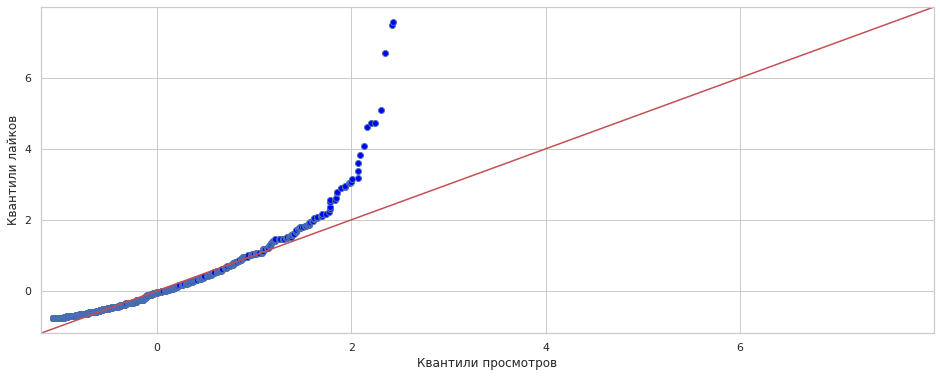

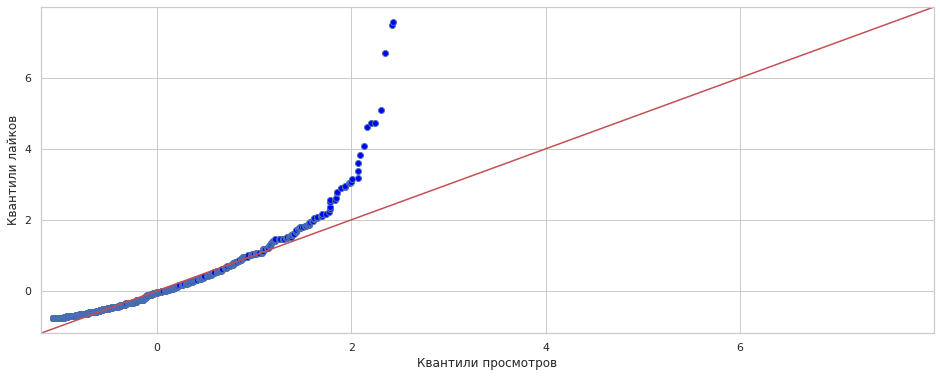

In [8]:
qqplot_2samples(z_data["like"], z_data["view"], line="45", xlabel="Квантили просмотров", ylabel="Квантили лайков")

<AxesSubplot:xlabel='ctr', ylabel='Count'>

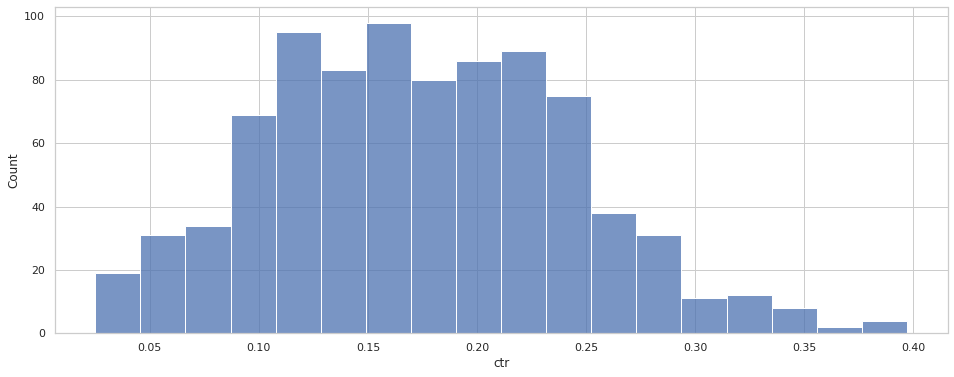

In [9]:
agg_df['ctr'] = agg_df['like'] / agg_df['view']

sns.histplot(x="ctr", data=agg_df)

In [12]:
#ищем первое и последнее время появления каждого поста в датафрейме
lifetime = df.groupby("post_id", as_index = False).agg({"time":["min", "max"]}) 

#у нас вышел мультииндекс в колонках 
#поэтому обращаемся к ним вот таким странным образом
#разницу между последним и первым мы обращаем в секунды

lifetime["lifetime"] = (lifetime[("time", "max")] - 
                        lifetime[("time", "min")])/np.timedelta64(1, 's')
lifetime = lifetime.drop([("time", "min"), ("time", "max")], axis=1) #избавляемся от лишнего

lifetime.head()

,post_id,lifetime
,,
0,1,50983.0
1,2,28633.0
2,3,44241.0
3,4,37131.0
4,5,37727.0


In [14]:
lifetime["lifetime"].mean() / 3600

1.8853045891008853

In [15]:
all_cols = agg_df.sort_values("post_id").merge(lifetime.sort_values("post_id"), 
                                               on="post_id", how="inner").drop("post_id", 
                                                                                axis=1)

#строим коррматрицу по Кэндаллу
#можно взять другой вид корреляции 
#но всё равно видно, что лайки и посты коррелируют сильнее всего
all_cols.corr(method = "kendall")

/nfs/env/lib/python3.8/site-packages/pandas/core/frame.py:9191: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,like,view,ctr,"(lifetime, )"
like,1.000000,0.866523,0.621104,0.079624
view,0.866523,1.000000,0.475467,0.131703
ctr,0.621104,0.475467,1.000000,-0.019233
"(lifetime, )",0.079624,0.131703,-0.019233,1.000000


/nfs/env/lib/python3.8/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/nfs/env/lib/python3.8/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/nfs/env/lib/python3.8/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you m

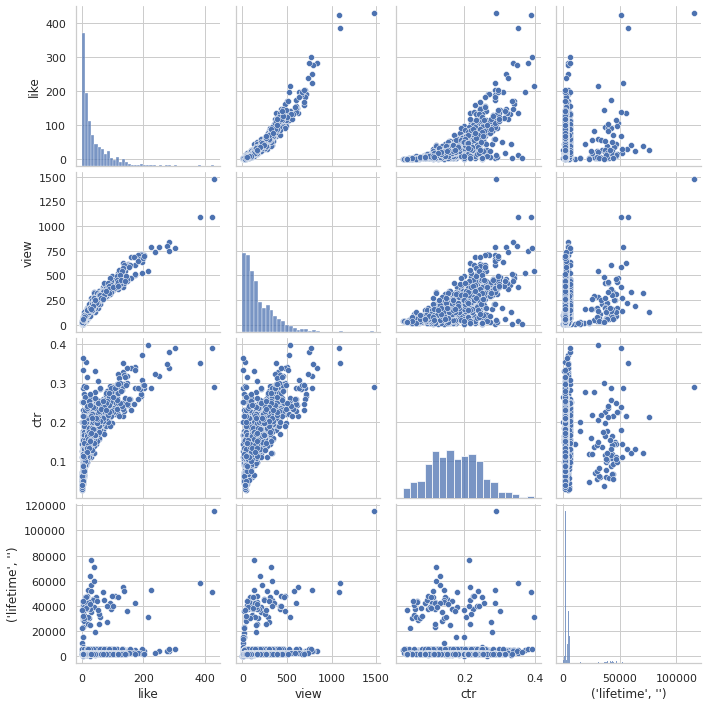

In [16]:
sns.pairplot(all_cols)

<AxesSubplot:xlabel='time'>

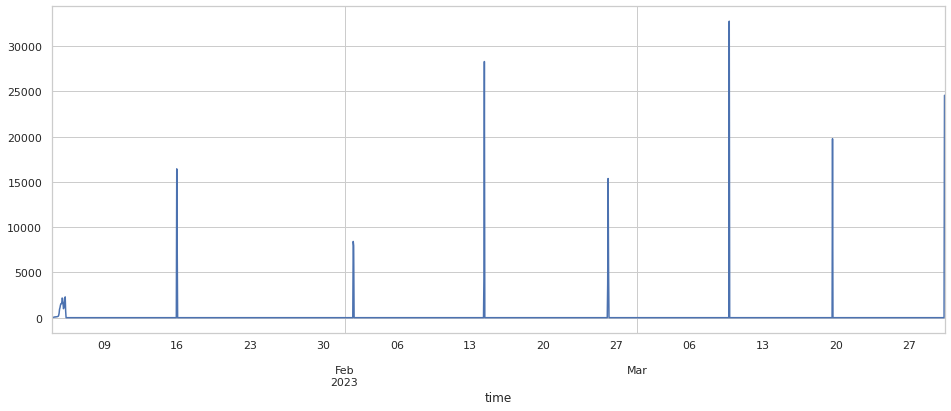

In [18]:
df.set_index("time").resample(rule="H").action.count().plot()

<AxesSubplot:xlabel='time'>

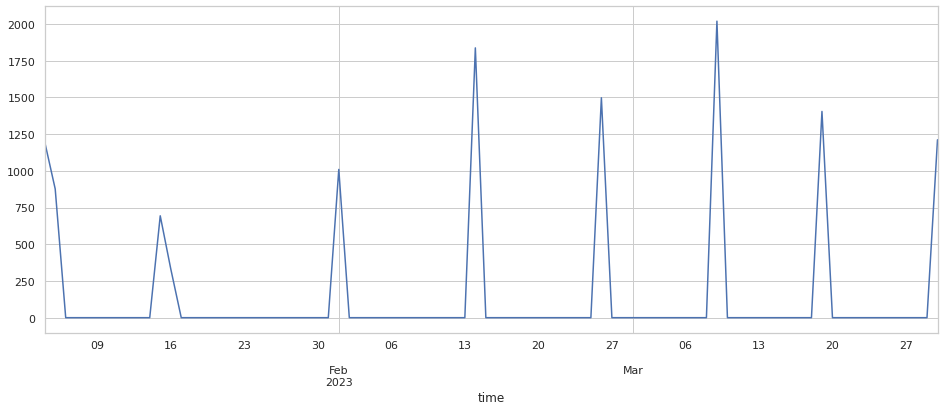

In [20]:
df.set_index("time").resample(rule="D").user_id.nunique().plot()

<AxesSubplot:xlabel='time'>

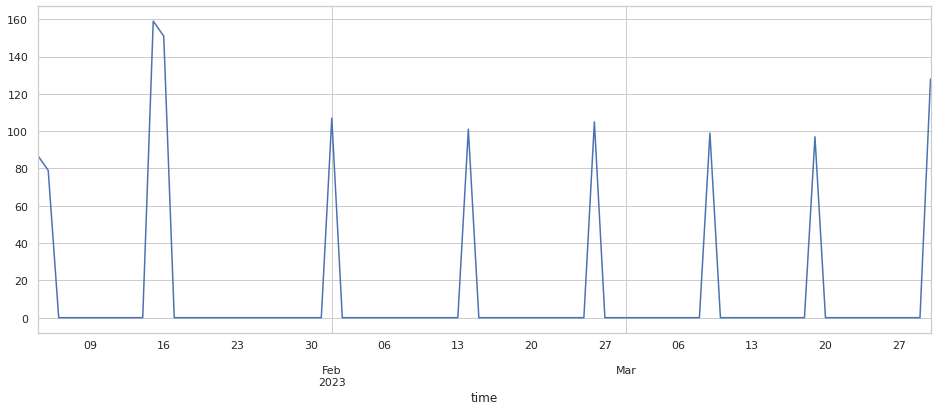

In [22]:
df.set_index("time").resample(rule="D").post_id.nunique().plot()

In [23]:
global_time = df.set_index("time").resample(rule="H").action.count()

#можно поиграться с параметрами сезонности, тренда и другими аргументами функции

res = STL(global_time, robust=True).fit() #сделаем менее подверженную выбросам декомпозицию
res.plot()

NameError: name 'STL' is not defined

<AxesSubplot:xlabel='hour', ylabel='user_id'>

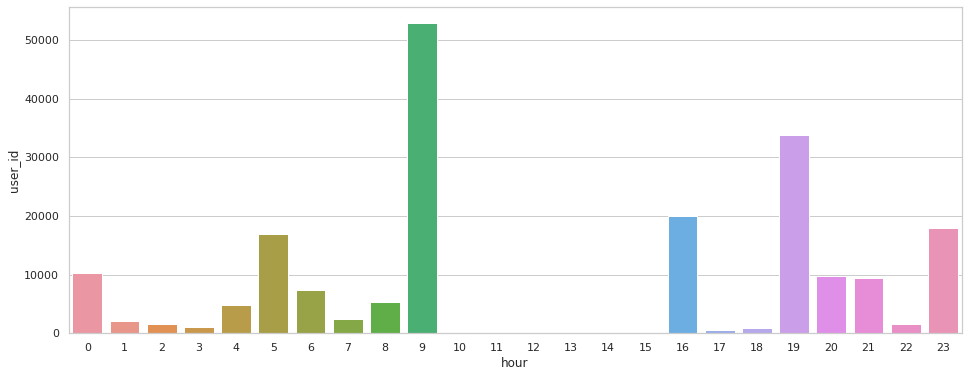

In [26]:
df["hour"] = df.time.dt.hour #извлекаем часовую часть времени
users = df.groupby("hour", as_index=False).user_id.count()

sns.barplot(x="hour", y="user_id", data=users)

<AxesSubplot:xlabel='hour', ylabel='post_id'>

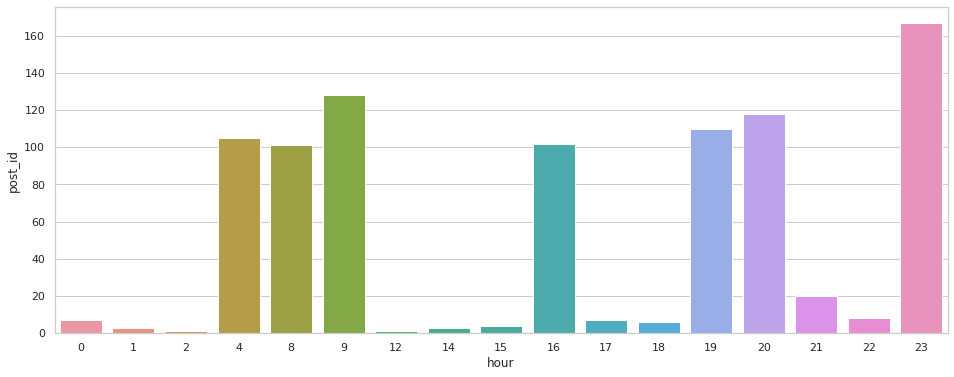

In [27]:
#надо найти, когда в первый раз встречается каждый пост
first_occurence = df.groupby("post_id", as_index=False).time.min()

#извлечём час дня, как в прошлый раз
first_occurence["hour"] = first_occurence.time.dt.hour

#считаем посты
posts = first_occurence.groupby("hour", as_index=False).post_id.count()

sns.barplot(x="hour", y="post_id", data=posts)